# Static Bandits

In [13]:
import numpy as np
from numpy.random import choice
import pandas as pd
from random import random
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

In [3]:
class Greedy(object):
    def __init__(self, n_arms, 
                 default_count=1.0, 
                 default_value=1.0):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.n = n_arms
        self.default_count = default_count
        self.default_value = default_value

    def choose_arm(self):
        return np.argmax(self.values)

    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value
        
    def update(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        new_value = ((n - 1) / float(n)) * value 
        new_value += (1 / float(n)) * reward
        self.values[arm] = new_value
    
    def get_arm_data(self):
        return zip(self.values, np.zeros(self.n))

In [4]:
class EpsilonGreedy(object):
    def __init__(self, n_arms, epsilon=0.1, 
                 default_count=1.0, 
                 default_value=1.0):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.epsilon = epsilon
        self.n = n_arms
        self.default_count = default_count
        self.default_value = default_value

    def choose_arm(self):
        if np.random.random() > self.epsilon:
            return np.argmax(self.values)
        else:
            return np.random.randint(self.n)

    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value
        
    def update(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        new_value = ((n - 1) / float(n)) * value 
        new_value += (1 / float(n)) * reward
        self.values[arm] = new_value
    
    def get_arm_data(self):
        return zip(self.values, np.zeros(self.n))

In [5]:
class EpsilonDecreasing(object):
    def __init__(self, n_arms, 
                 default_count=1.0, 
                 default_value=1.0):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.n = n_arms
        self.epsilon = (2*self.n)
        self.epsilon /= (self.counts.sum() + 2*self.n)
        self.default_count = default_count
        self.default_value = default_value

    def choose_arm(self):
        self.epsilon = (2*self.n) 
        self.epsilon /= (self.counts.sum() + 2*self.n)
        if np.random.random() > self.epsilon:
            return np.argmax(self.values)
        else:
            return np.random.randint(self.n)

    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value
        
    def update(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        new_value = ((n - 1) / float(n)) * value
        new_value += (1 / float(n)) * reward
        self.values[arm] = new_value
    
    def get_arm_data(self):
        return zip(self.values, np.zeros(self.n))

In [6]:
class UCB(object):
    def __init__(self, n_arms=2, 
                 default_count=1.0, 
                 default_value=1.0):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.n = n_arms
        self.default_count = default_count
        self.default_value = default_value
        self.delta = 0.015

    def choose_arm(self):
        ucbs = [0.]*self.n
        T = self.counts.sum()
        for i in range(self.n):
            p = self.values[i]
            n = self.counts[i]
            ucb = p + self.delta*sqrt(2*T/n)
            ucbs[i] = ucb
        return np.argmax(ucbs)
    
    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value

    def update(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        new_value = ((n - 1) / float(n)) * value 
        new_value += (1 / float(n)) * reward
        self.values[arm] = new_value
    
    def get_arm_data(self):
        ci = np.zeros(self.n)
        T = self.counts.sum()
        for i in range(self.n):
            p = self.values[i]
            n = self.counts[i]
            ci[i] = self.delta*sqrt(2*T/float(n))
        return zip(self.values, ci)

In [7]:
def gen_static_uniform(k = 2, T = 10):
    temp = np.random.rand(k)
    rewards = np.zeros((T, k))
    for t in range(T):
        rewards[t] += temp
    return rewards

In [8]:
def gen_static_beta(k = 2, T = 10,
                   a = 2, b = 10):
    temp = np.random.beta(a, b, k)
    rewards = np.zeros((T, k))
    for t in range(T):
        rewards[t] += temp
    return rewards

In [18]:
def plot_static(actual, title='uniform',
               fs = (10,5),
               colormap = plt.cm.cool,
               ax = None):
    if not ax:
        fig, ax = plt.subplots(figsize=fs)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('time')
    ax.set_ylabel('rewards')
    ax.grid('off')
    xs = range(len(actual))
    k = actual.shape[1]
    for i in range(k):
        color = colormap(float(i)/k)
        ax.plot(xs, actual[:,i].tolist(), 
                c=color, alpha=1.0, 
                label=str(i)+' actual', 
                linewidth=2)
        

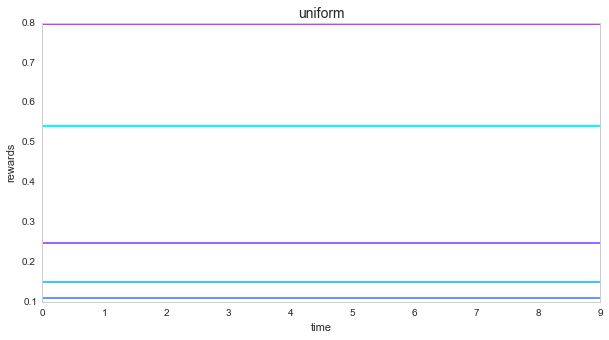

In [19]:
actual = gen_static_uniform(5, 10)
plot_static(actual, 'uniform')

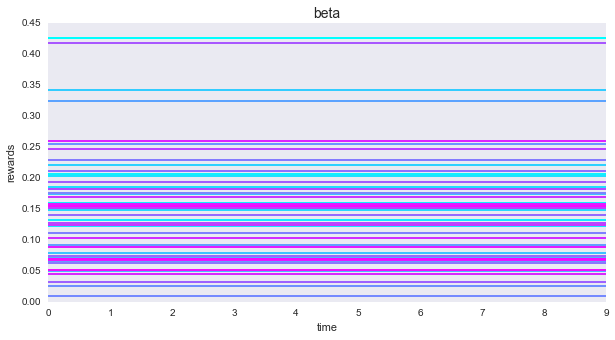

In [11]:
actual = gen_static_beta(50, 10)
plot_static(actual, 'beta')

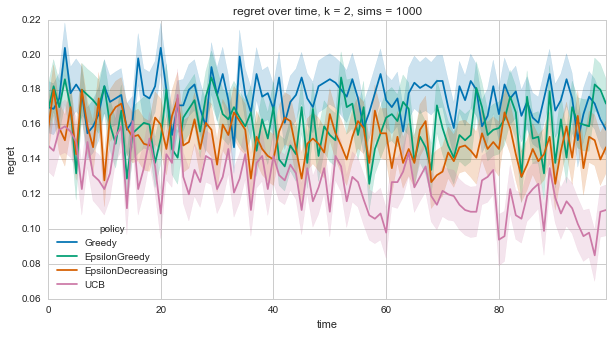

In [33]:
# test static, non-volatile data
def test_static(k = 2, T = 10, 
                actual = None, 
                bandit = None):
    rewards = []
    arm_data = []
    regret = []
    arms_selected = np.zeros((T, k))
    choices = range(k)
    for t in range(T):
        arm = bandit.choose_arm()
        actual_best = np.max(actual[t])
        reward = 0.0
        if actual[t][arm] > np.random.random():
            reward = 1.0
        
        regret.append(actual_best - reward)
        rewards.append(reward)
        arm_data.append(bandit.get_arm_data())
        bandit.update(arm, reward)
    rewards = np.array(rewards)
    arm_data = np.array(arm_data)
    regret = np.array(regret)
    return rewards, arm_data, regret

def rolling_mean(lst):
    m = np.zeros(len(lst))
    l = m.shape[0]
    r = 20
    for i in range(len(lst)):
        if i < r:
            m[i] = np.mean(lst[:r-i+1])
        elif i > l-r:
            m[i] = np.mean(lst[i:])
        else:
            m[i] = np.mean(lst[i-r:i+r])
    return m

def plot_regret(regret, ax, color, label=''):
    ax.plot(range(len(regret)), rolling_mean(regret), 
            c = color, label=label)
    
def sim():
    nsims = 1000
    T = 100
    k = 2
    bandits = [Greedy(k),
               EpsilonGreedy(k, 0.01),
               EpsilonDecreasing(k),
               UCB(k)]
    ts = pd.Series(range(T))
    df_final = None
    
    for sim in range(nsims):
        actual = gen_static_uniform(k, T)
        for i, bandit in enumerate(bandits):
            rewards, arm_data, regret = test_static(k, T, actual, bandit)
            rewards = rewards.tolist()
            df = pd.DataFrame(ts, columns=['time'])
            df['policy'] = [bandit.__class__.__name__]*T
            df['regret'] = regret
            df['sim'] = pd.Series([sim]*T)
            if df_final is None:
                df_final = df
            else:
                df_final = pd.concat([df_final, df], ignore_index=True)
    fig, ax = plt.subplots(figsize=(10,5), dpi=200)
    ax.set_title('regret over time, k = '+str(k)+', sims = '+str(nsims))
    sb.set_palette('colorblind')
    sb.set_style("whitegrid")
    sb.tsplot(df_final, time='time', unit='sim', value='regret', condition='policy', ax=ax)
    
sim()

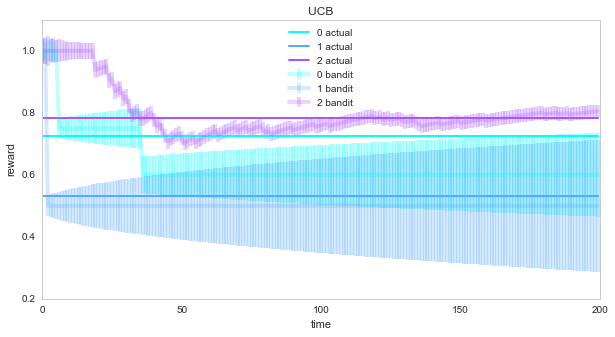

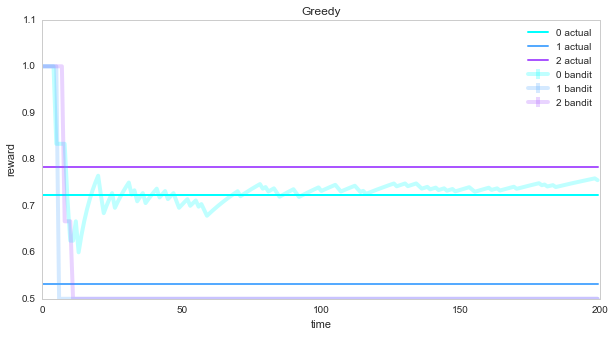

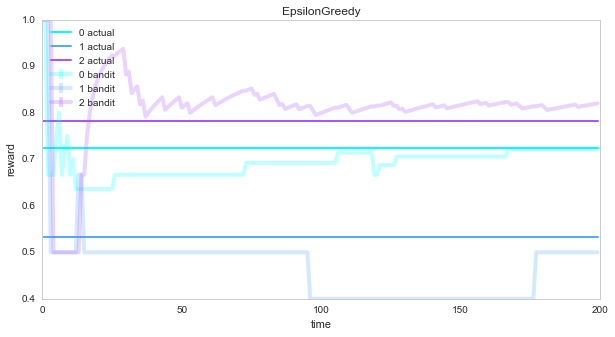

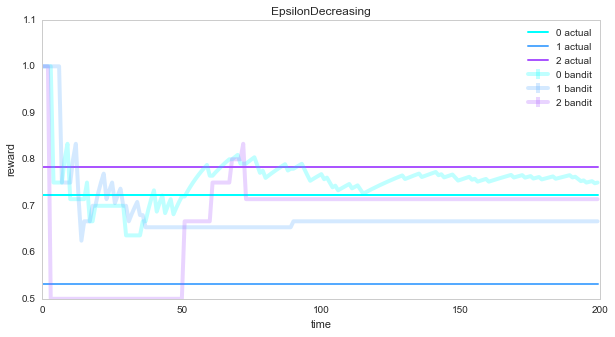

In [32]:
def plot_arm_data_plus_actual(arm_data, actual, 
                              fs=(10,5), 
                              colormap = plt.cm.cool,
                              fig_title='title'):
    fig, ax = plt.subplots(figsize=fs)
    #res = transform_volatile_for_plotting(actual, news)
    #plot_volatile_static_data(res, ax)
    plot_static(actual, ax=ax)
    ax.set_title(fig_title); ax.grid('off')
    ax.set_xlabel('time'); ax.set_ylabel('reward')
    k = arm_data.shape[1]
    for i in range(k):
        color = colormap(i/float(k))
        xs = range(len(arm_data))
        ys = [e[i][0] for e in arm_data]
        err = [(e[i][1]) for e in arm_data]
        ax.errorbar(xs, ys, yerr=err, c=color, 
                    alpha=0.25, label=str(i)+' bandit',
                    linewidth=4)
    ax.legend(loc='best')

def demo_bandits():
    k, T = 3, 200
    actual = gen_static_uniform(k, T)
    bandits = [UCB(n_arms=k),
               Greedy(k),
               EpsilonGreedy(k, 0.1),
               EpsilonDecreasing(k)]
    for b in bandits:
        rewards, arm_data, regret = test_static(k, T, 
                                                actual, b)
        bandit_name = b.__class__.__name__
        plot_arm_data_plus_actual(arm_data, actual, 
                                  fig_title=bandit_name)
        
demo_bandits()